## Imports

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.cloud import storage
import os
from io import StringIO
from itertools import islice
from prophet import Prophet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [261]:
file_name = 'IWC_Work_Orders_Extract.csv'

df = pd.read_csv(file_name, low_memory=False)
print("File loaded from local storage.")

File loaded from local storage.


In [262]:
# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [263]:
df['START_YEAR_MONTH'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.strftime('%Y-%m')
df['MONTH'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.month
df['YEAR'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.year
df['WEEK'] = pd.to_datetime(df['EXECUTION_START_DATE']).dt.strftime('%W')

## Filtering

In [264]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,START_YEAR_MONTH,MONTH,YEAR,WEEK
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2024-05,5,2024,18
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-09,9,2022,37
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-12,12,2022,51
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,2022-07,7,2022,27
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,NaT,2023-03,3,2023,11


## Finding Aggregate Time Values


In [265]:
grouped_df = df.groupby(['PRODUCTION_LOCATION', 'MAINTENANCE_ACTIVITY_TYPE', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID']).agg(
    average_minutes = ('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count = ('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

In [266]:
pivoted_df = grouped_df.pivot_table(
    index=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'], 
    columns='MAINTENANCE_ACTIVITY_TYPE', 
    values=['average_minutes', 'count']
).reset_index()

pivoted_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in pivoted_df.columns]

pivoted_df['time_saved'] = (pivoted_df['average_minutes_Unplanned'] - pivoted_df['average_minutes_Planned']) / pivoted_df['average_minutes_Unplanned'] * 100

pivoted_df = pivoted_df.rename(columns=lambda x: x.rstrip('_'))

In [267]:
aggregate_times = pivoted_df[(pivoted_df['count_Planned'] > 50) & (pivoted_df['count_Unplanned'] > 50) & (pivoted_df['time_saved'] > 0)]

In [268]:
aggregate_times.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 16 to 2820
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   PRODUCTION_LOCATION              235 non-null    object 
 1   FUNCTIONAL_AREA_NODE_2_MODIFIED  235 non-null    object 
 2   EQUIPMENT_ID                     235 non-null    float64
 3   average_minutes_Planned          235 non-null    float64
 4   average_minutes_Unplanned        235 non-null    float64
 5   count_Planned                    235 non-null    float64
 6   count_Unplanned                  235 non-null    float64
 7   time_saved                       235 non-null    float64
dtypes: float64(6), object(2)
memory usage: 16.5+ KB


## Lifespan

In [269]:
df_filtered = df[df['EQUIPMENT_ID'].isin(aggregate_times['EQUIPMENT_ID'])]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148499 entries, 662 to 1427263
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   ORDER_ID                         148499 non-null  int64         
 1   PLANT_ID                         148499 non-null  object        
 2   PRODUCTION_LOCATION              148499 non-null  object        
 3   EXECUTION_START_DATE             148499 non-null  datetime64[ns]
 4   EXECUTION_FINISH_DATE            148499 non-null  datetime64[ns]
 5   ACTUAL_START_TIME                148499 non-null  object        
 6   ACTUAL_FINISH_TIME               148499 non-null  object        
 7   ACTUAL_WORK_IN_MINUTES           148499 non-null  float64       
 8   MAINTENANCE_PLAN                 73806 non-null   object        
 9   MAINTENANCE_ITEM                 73806 non-null   float64       
 10  MAINTENANCE_ACTIVITY_TYPE        148499 non-nu

In [270]:
selected_columns = ['ORDER_ID', 'PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES']
sm_df_filtered = df_filtered[selected_columns].sort_values(selected_columns)

# Aggregate the data
sm_df_filtered_agg = sm_df_filtered.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE']).agg(
    counts=('EQUIPMENT_ID', 'size'),
    total_mins=('ACTUAL_WORK_IN_MINUTES', 'sum')
).reset_index()

# Find the last execution date
sm_df_filtered_agg['PREV_EXECUTION_FINISH_DATE'] = sm_df_filtered_agg.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'])['EXECUTION_FINISH_DATE'].shift(1)

# Replace NaN values for the first occurrence
sm_df_filtered_agg['PREV_EXECUTION_FINISH_DATE'] = sm_df_filtered_agg['PREV_EXECUTION_FINISH_DATE'].fillna(sm_df_filtered_agg['EXECUTION_START_DATE'])

# Calculate lifespan (time difference in days between consecutive executions)
sm_df_filtered_agg['LIFE'] = (sm_df_filtered_agg['EXECUTION_START_DATE'] - sm_df_filtered_agg['PREV_EXECUTION_FINISH_DATE']).dt.days
sm_df_filtered_agg['LIFE'] = sm_df_filtered_agg['LIFE'].fillna(pd.NA)

# Compute weighted mean lifespan and mean time maintenance
workable_df = sm_df_filtered_agg
weighted_life = workable_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID']).apply(
    lambda x: pd.Series({
        'WEIGHTED_MEAN_LIFESPAN': (x['LIFE'] * x['counts']).sum() / x['counts'].sum(),
        'MEAN_TIME_MAINTENENCE': x['total_mins'].mean()
    })
).reset_index()

# Select final columns from the original data
selected_columns = ['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID', 'EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'ACTUAL_WORK_IN_MINUTES', 'PREV_EXECUTION_FINISH_DATE', 'LIFE']
df_filtered_filtered = sm_df_filtered.filter(selected_columns)

# Merge the calculated weighted mean lifespan back to the original filtered dataset
df_lifespan = pd.merge(df_filtered_filtered, weighted_life, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'], how='left')

# Add the weighted mean lifespan as timedelta to the execution finish date
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = df_lifespan['EXECUTION_FINISH_DATE'] + pd.to_timedelta(df_lifespan['WEIGHTED_MEAN_LIFESPAN'], unit='D')

# Ensure the EXPECTED_MAINTENANCE_DATE is in datetime format
df_lifespan['EXPECTED_MAINTENANCE_DATE'] = pd.to_datetime(df_lifespan['EXPECTED_MAINTENANCE_DATE'])

# Find the actual next maintenance date (next execution start date)
df_lifespan['ACTUAL_NEXT_MAINTENACE'] = pd.to_datetime(df_lifespan.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'])['EXECUTION_START_DATE'].shift(-1))

# Calculate the difference between the expected and actual maintenance dates
df_lifespan['EXPECTED_DIFFERENCE'] = (df_lifespan['EXPECTED_MAINTENANCE_DATE'] - df_lifespan['ACTUAL_NEXT_MAINTENACE']).dt.days

# Display the final dataset
df_lifespan

/var/folders/48/lqnzfz_50qx1c2hqrjm1fbs80000gn/T/ipykernel_32510/3333433505.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_life = workable_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID']).apply(


,PRODUCTION_LOCATION,FUNCTIONAL_AREA_NODE_2_MODIFIED,EQUIPMENT_ID,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_WORK_IN_MINUTES,WEIGHTED_MEAN_LIFESPAN,MEAN_TIME_MAINTENENCE,EXPECTED_MAINTENANCE_DATE,ACTUAL_NEXT_MAINTENACE,EXPECTED_DIFFERENCE
0,MONZA,BTL_PET_LINE,300001559.0,2017-03-08,2017-03-08,30.0,5.136719,83.792427,2017-03-13 03:16:52.500000000,2017-03-06,7.0
1,MONZA,BTL_PET_LINE,300001560.0,2017-03-08,2017-03-08,60.0,6.020408,68.467573,2017-03-14 00:29:23.265306121,2017-03-06,8.0
2,MONZA,BTL_PET_LINE,300001113.0,2017-03-05,2017-03-05,30.0,0.140979,126.380143,2017-03-05 03:23:00.569758948,2017-03-08,-3.0
3,MONZA,BTL_PET_LINE,300001611.0,2017-02-27,2017-02-27,600.0,4.702306,135.981687,2017-03-03 16:51:19.245283021,2017-03-25,-22.0
4,MONZA,BTL_PET_LINE,300001509.0,2017-03-15,2017-03-15,45.0,1.527137,228.612487,2017-03-16 12:39:04.640434191,2017-03-06,10.0
...,...,...,...,...,...,...,...,...,...,...,...
148494,SUZUKA,"L1, L2, L6 PET BOTTLE LINES",300009177.0,2018-05-16,2018-05-16,90.0,1.740692,328.254500,2018-05-17 17:46:35.795006569,NaT,NaN
148495,SUZUKA,"L1, L2, L6 PET BOTTLE LINES",300009097.0,2019-01-19,2019-01-19,30.0,5.160126,144.625105,2019-01-24 03:50:34.850863420,NaT,NaN
148496,SUZUKA,"L1, L2, L6 PET BOTTLE LINES",300009113.0,2019-03-19,2019-03-19,6.0,3.993895,151.272668,2019-03-22 23:51:12.527472528,NaT,NaN
148497,SUZUKA,"L1, L2, L6 PET BOTTLE LINES",300009176.0,2019-03-23,2019-03-23,180.0,21.943089,61.075862,2019-04-13 22:38:02.926829267,NaT,NaN


## Prophet

In [271]:
df_filtered_monza = df[df['EQUIPMENT_ID'].isin(aggregate_times['EQUIPMENT_ID']) & (df['PRODUCTION_LOCATION'] == 'MONZA')]

df_filtered_monza.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27151 entries, 4407 to 1381340
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ORDER_ID                         27151 non-null  int64         
 1   PLANT_ID                         27151 non-null  object        
 2   PRODUCTION_LOCATION              27151 non-null  object        
 3   EXECUTION_START_DATE             27151 non-null  datetime64[ns]
 4   EXECUTION_FINISH_DATE            27151 non-null  datetime64[ns]
 5   ACTUAL_START_TIME                27151 non-null  object        
 6   ACTUAL_FINISH_TIME               27151 non-null  object        
 7   ACTUAL_WORK_IN_MINUTES           27151 non-null  float64       
 8   MAINTENANCE_PLAN                 22656 non-null  object        
 9   MAINTENANCE_ITEM                 22656 non-null  float64       
 10  MAINTENANCE_ACTIVITY_TYPE        27151 non-null  object   

In [272]:
df_monza_aggregated = df_filtered_monza.groupby(['EXECUTION_START_DATE', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID']).size().reset_index(name='work_order_count')

df_monza_aggregated

,EXECUTION_START_DATE,FUNCTIONAL_AREA_NODE_2_MODIFIED,EQUIPMENT_ID,work_order_count
0,2017-02-27,BTL_PET_LINE,300001611.0,1
1,2017-02-28,BTL_PET_LINE,300001119.0,1
2,2017-02-28,BTL_PET_LINE,300001248.0,1
3,2017-02-28,BTL_PET_LINE,300001580.0,1
4,2017-02-28,ROTARY_CAN_LINE,300001078.0,3
...,...,...,...,...
16176,2024-08-29,BTL_PET_LINE,300001133.0,1
16177,2024-08-29,BTL_PET_LINE,300001273.0,1
16178,2024-08-29,BTL_PET_LINE,300001559.0,1
16179,2024-08-29,BTL_PET_LINE,300001611.0,1


In [273]:
# Initialize a dictionary to store models
models = {}

# Iterate through unique FUNCTIONAL_AREA_NODE_2_MODIFIED first
functional_areas = df_monza_aggregated['FUNCTIONAL_AREA_NODE_2_MODIFIED'].unique()

for functional_area in functional_areas:
    # Get unique EQUIPMENT_IDs for this functional area
    equipment_ids = df_monza_aggregated[df_monza_aggregated['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == functional_area]['EQUIPMENT_ID'].unique()
    
    # Iterate over a subset of equipment_ids (e.g., first 10)
    for equipment_id in islice(equipment_ids, 0, 10):
        # Filter data for each functional area and equipment combination
        equipment_data = df_monza_aggregated[(df_monza_aggregated['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == functional_area) & 
                                             (df_monza_aggregated['EQUIPMENT_ID'] == equipment_id)]
        
        # Rename columns for Prophet
        equipment_data = equipment_data.rename(columns={'EXECUTION_START_DATE': 'ds', 
                                                        'work_order_count': 'y'})
        
        # Ensure there are at least two non-NaN rows for Prophet
        if equipment_data.dropna().shape[0] >= 2:
            # Initialize and fit Prophet model
            model = Prophet()
            model.fit(equipment_data)
            
            # Store the model with a tuple key (functional_area, equipment_id)
            models[(functional_area, equipment_id)] = model
        else:
            print(f"Skipping (functional_area: {functional_area}, equipment_id: {equipment_id}) due to insufficient data.")

# Now, the `models` dictionary will have keys as tuples (functional_area, equipment_id) 
# and the corresponding Prophet models as values.

00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1] done processing
00:27:45 - cmdstanpy - INFO - Chain [1] start processing
00:27:45 - cmdstanpy - INFO - Chain [1]

In [274]:
# Lots of skipped models, need to revisit this

In [275]:
# for key, model in models.items():
#     print(f"Key: {key}, Model: {model}")

In [277]:
# Print the number of models stored in the dictionary
print(f"Number of models created: {len(models)}")


Number of models created: 18


In [278]:
# Number of days to forecast
days_to_forecast = 30

# Dictionary to store forecasts for each model
forecasts = {}

# Loop through each model in the models dictionary
for (functional_area, equipment_id), model in models.items():
    # Create a DataFrame of future dates (for the next 30 days) for each model
    future_dates = model.make_future_dataframe(periods=days_to_forecast)
    
    # Generate the forecast using the model's predict method
    forecast = model.predict(future_dates)
    
    # Store the forecast in the forecasts dictionary
    forecasts[(functional_area, equipment_id)] = forecast
    
    # Optionally, print or inspect the forecast
    print(f"Forecast for Functional Area: {functional_area}, Equipment ID: {equipment_id}")
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())  # Show first 5 predictions

# Now, `forecasts` will contain the predicted results for each model


Forecast for Functional Area: BTL_PET_LINE, Equipment ID: 300001611.0
          ds      yhat  yhat_lower  yhat_upper
0 2017-02-27  1.020494    0.414107    1.649028
1 2017-03-25  0.977326    0.307523    1.592589
2 2017-04-05  0.948194    0.370615    1.633226
3 2017-04-10  0.878660    0.233846    1.498573
4 2017-04-29  0.988148    0.383802    1.598838
Forecast for Functional Area: BTL_PET_LINE, Equipment ID: 300001119.0
          ds      yhat  yhat_lower  yhat_upper
0 2017-02-28  1.209869    0.431958    1.875340
1 2017-03-10  1.040323    0.302565    1.806995
2 2017-03-25  1.135597    0.371824    1.875804
3 2017-04-11  1.166172    0.474284    1.876338
4 2017-04-21  1.153055    0.380512    1.880686
Forecast for Functional Area: BTL_PET_LINE, Equipment ID: 300001248.0
          ds      yhat  yhat_lower  yhat_upper
0 2017-02-28  2.389271    0.758823    3.881304
1 2017-03-09  2.247219    0.755645    3.754837
2 2017-03-10  2.189115    0.764993    3.720827
3 2017-03-15  2.230584    0.812131    

In [279]:
# Create an empty DataFrame to store the results
combined_df = pd.DataFrame()

# Loop through each model and corresponding forecast in the dictionary
for (functional_area, equipment_id), model in models.items():
    # Filter the original data for the specific functional_area and equipment_id
    original_data = df_monza_aggregated[(df_monza_aggregated['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == functional_area) &
                                        (df_monza_aggregated['EQUIPMENT_ID'] == equipment_id)].copy()

    # Rename columns for consistency
    original_data = original_data.rename(columns={'EXECUTION_START_DATE': 'ds', 'work_order_count': 'y'})
    
    # Mark the original data as real
    original_data['source'] = 'real'

    # Create future dates for prediction (for the next 30 days, for example)
    future_dates = model.make_future_dataframe(periods=30)
    
    # Generate predictions
    forecast = model.predict(future_dates)
    
    # Rename columns in forecast to match the original data (ds and yhat for predictions)
    forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': 'y'})
    
    # Mark the forecast data as predicted
    forecast['source'] = 'predicted'

    # Combine the original data and the forecast data
    combined_data = pd.concat([original_data, forecast], ignore_index=True)
    
    # Add the functional area and equipment ID to the combined data
    combined_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'] = functional_area
    combined_data['EQUIPMENT_ID'] = equipment_id

    # Append to the final combined DataFrame
    combined_df = pd.concat([combined_df, combined_data], ignore_index=True)

# Display the combined DataFrame with both real and predicted values
print(combined_df[['ds', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID', 'y', 'source']].head(20))


           ds FUNCTIONAL_AREA_NODE_2_MODIFIED  EQUIPMENT_ID    y source
0  2017-02-27                    BTL_PET_LINE   300001611.0  1.0   real
1  2017-03-25                    BTL_PET_LINE   300001611.0  1.0   real
2  2017-04-05                    BTL_PET_LINE   300001611.0  1.0   real
3  2017-04-10                    BTL_PET_LINE   300001611.0  1.0   real
4  2017-04-29                    BTL_PET_LINE   300001611.0  1.0   real
5  2017-05-16                    BTL_PET_LINE   300001611.0  1.0   real
6  2017-05-27                    BTL_PET_LINE   300001611.0  2.0   real
7  2017-06-02                    BTL_PET_LINE   300001611.0  1.0   real
8  2017-06-27                    BTL_PET_LINE   300001611.0  1.0   real
9  2017-07-09                    BTL_PET_LINE   300001611.0  1.0   real
10 2017-07-14                    BTL_PET_LINE   300001611.0  1.0   real
11 2017-07-26                    BTL_PET_LINE   300001611.0  1.0   real
12 2017-07-31                    BTL_PET_LINE   300001611.0  1.0

In [293]:
combined_df.tail(100)

,ds,FUNCTIONAL_AREA_NODE_2_MODIFIED,EQUIPMENT_ID,y,source,PRODUCTION_LOCATION,average_minutes_Planned,average_minutes_Unplanned,count_Planned,count_Unplanned,time_saved,planned_minutes,unplanned_minutes
23520,2024-02-18,ROTARY_CAN_LINE,300076805.0,1.033740,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,26.427784,325.863431
23521,2024-02-19,ROTARY_CAN_LINE,300076805.0,1.018349,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,26.034311,321.011780
23522,2024-02-20,ROTARY_CAN_LINE,300076805.0,1.176358,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,30.073854,370.820690
23523,2024-02-22,ROTARY_CAN_LINE,300076805.0,1.179786,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,30.161482,371.901179
23524,2024-02-24,ROTARY_CAN_LINE,300076805.0,1.016200,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,25.979364,320.334256
23525,2024-02-26,ROTARY_CAN_LINE,300076805.0,1.202362,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,30.738651,379.017858
23526,2024-02-27,ROTARY_CAN_LINE,300076805.0,1.359304,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,34.750914,428.490404
23527,2024-02-28,ROTARY_CAN_LINE,300076805.0,1.322983,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,33.822354,417.040956
23528,2024-02-29,ROTARY_CAN_LINE,300076805.0,1.351129,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,34.541896,425.913146
23529,2024-03-03,ROTARY_CAN_LINE,300076805.0,1.347556,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,34.450573,424.787101


In [282]:
combined_df = pd.merge(combined_df, aggregate_times, on=['FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_ID'], how='left')

combined_df['planned_minutes'] = (combined_df['y']) * (combined_df['average_minutes_Planned'])
combined_df['unplanned_minutes'] = (combined_df['y']) * (combined_df['average_minutes_Unplanned'])

combined_df.dropna(how='any', axis=0, inplace=True)

In [283]:
combined_df.tail()

,ds,FUNCTIONAL_AREA_NODE_2_MODIFIED,EQUIPMENT_ID,y,source,PRODUCTION_LOCATION,average_minutes_Planned,average_minutes_Unplanned,count_Planned,count_Unplanned,time_saved,planned_minutes,unplanned_minutes
23615,2024-09-22,ROTARY_CAN_LINE,300076805.0,1.063570,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,27.190408,335.266840
23616,2024-09-23,ROTARY_CAN_LINE,300076805.0,1.011387,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,25.856332,318.817235
23617,2024-09-24,ROTARY_CAN_LINE,300076805.0,1.133042,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,28.966474,357.166330
23618,2024-09-25,ROTARY_CAN_LINE,300076805.0,1.066011,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,27.252796,336.036104
23619,2024-09-26,ROTARY_CAN_LINE,300076805.0,1.068904,predicted,MONZA,25.565217,315.227692,69.0,195.0,91.88992,27.326771,336.948237


In [288]:
# Aggregate by taking the mean for the same date (if duplicates exist)
df_aggregated = combined_df.groupby(['ds', 'source']).agg({
    'planned_minutes': 'mean',
    'unplanned_minutes': 'mean'
}).reset_index()

# Separate real and predicted data again after aggregation
df_real = df_aggregated[df_aggregated['source'] == 'real']
df_predicted = df_aggregated[df_aggregated['source'] == 'predicted']

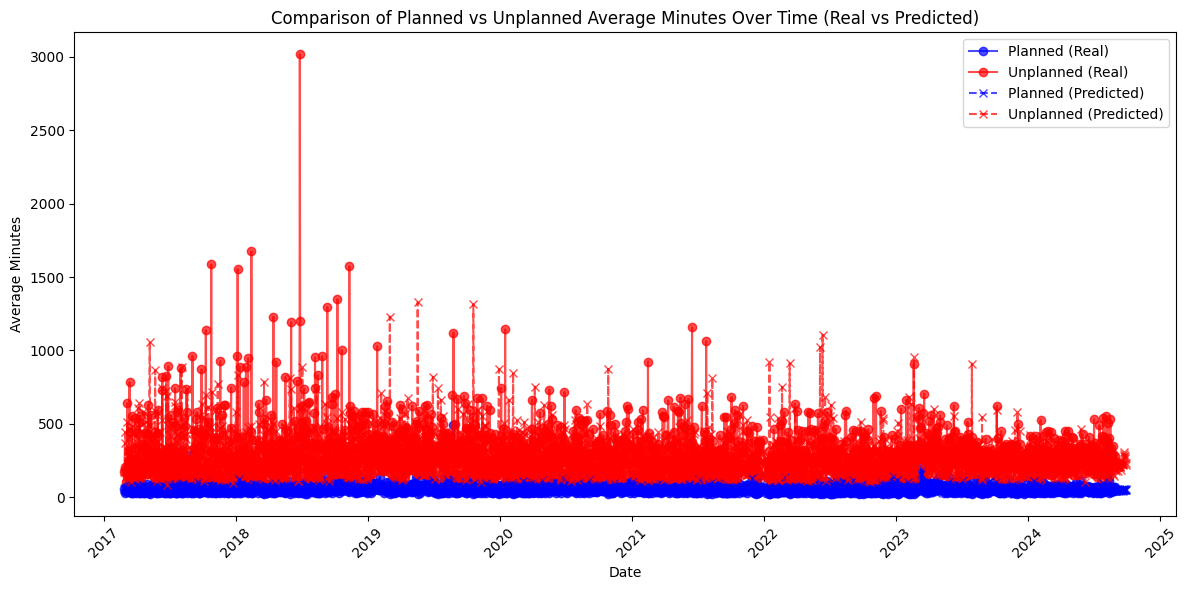

In [289]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot real data (with markers for better visibility)
plt.plot(df_real['ds'], df_real['planned_minutes'], label='Planned (Real)', color='blue', linestyle='-', marker='o', alpha=0.7)
plt.plot(df_real['ds'], df_real['unplanned_minutes'], label='Unplanned (Real)', color='red', linestyle='-', marker='o', alpha=0.7)

# Plot predicted data
plt.plot(df_predicted['ds'], df_predicted['planned_minutes'], label='Planned (Predicted)', color='blue', linestyle='--', marker='x', alpha=0.7)
plt.plot(df_predicted['ds'], df_predicted['unplanned_minutes'], label='Unplanned (Predicted)', color='red', linestyle='--', marker='x', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Average Minutes')
plt.title('Comparison of Planned vs Unplanned Average Minutes Over Time (Real vs Predicted)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()